In [54]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
import numpy as np
import seaborn as sns

In [46]:
# Configuración de rutas
base_dir = 'data'  # Reemplaza con la ruta principal donde están train, test, valid
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

In [45]:
# Generador de datos con normalización y aumento ajustado para el entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Reducir rotación
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Añadir flips verticales si es necesario
    brightness_range=[0.9, 1.1],  # Reducir el rango de brillo
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Crear los generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # ACTIVAR SHUFFLE para mezclar los datos en cada época
)

validation_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar en validación
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Mantener False para evitar desalineación
)

Found 23214 images belonging to 2 classes.
Found 3736 images belonging to 2 classes.
Found 5436 images belonging to 2 classes.


In [63]:
# Cargar el modelo base (DenseNet121)
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Descongelar las últimas capas del modelo base DenseNet121
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Descongelar solo las últimas 50 capas
    layer.trainable = False

In [65]:
# Añadir capas superiores personalizadas con regularización L2 y Dropout adicional
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)  # Capa final con 2 clases

# Crear el modelo completo
model = models.Model(inputs=base_model.input, outputs=outputs)

# Compilar el modelo con tasa de aprendizaje inicial ajustada
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

# Mostrar la arquitectura del modelo
model.summary()

# Configurar los pasos por época basados en el tamaño de datos y batch size
steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
validation_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

# Guardar el mejor modelo durante el entrenamiento
checkpoint_path = 'models/best_melanomaornot_model_02.keras'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_auc',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Parar temprano si no hay mejora
early_stopping = EarlyStopping(monitor='val_auc', patience=8, verbose=1, restore_best_weights=True, mode='max')

# Reducir la tasa de aprendizaje si no hay mejora
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=4, verbose=1, min_lr=1e-7, mode='max')



Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, 230, 230,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_21   │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_2… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,694,146 (29.35 MB)

 Trainable params: 1,732,290 (6.61 MB)

 Non-trainable params: 5,961,856 (22.74 MB)

In [67]:
# Registrar el historial de entrenamiento para reanudarlo en caso de interrupción
csv_logger = CSVLogger('training_log.csv', append=True)

# Callback personalizado para calcular AUC-ROC en cada época
class RocAucCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(validation_generator)
        val_true = validation_generator.classes
        auc = roc_auc_score(val_true, val_pred[:, 1])
        print(f'Epoch {epoch + 1} - val_auc: {auc:.4f}')

# Calcular los pesos de las clases basado en el número de muestras
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Si tienes un modelo guardado pero solo deseas cargar el modelo base (sin capas densas superiores):
if os.path.exists(checkpoint_path):
    try:
        # Cargar los pesos del modelo base (DenseNet121), omitir las capas superiores
        base_model.load_weights(checkpoint_path)
        print(f"Modelo base cargado desde {checkpoint_path}")
    except ValueError as e:
        print(f"No se pudieron cargar algunos pesos del modelo base: {str(e)}")

Modelo base cargado desde models/best_melanomaornot_model_02.keras


In [68]:
# Entrenar el modelo desde cero (sin intentar cargar pesos de capas superiores)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=[checkpoint, early_stopping, reduce_lr, csv_logger, RocAucCallback()],
    class_weight=dict(enumerate(class_weights))
)

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8224 - auc: 0.9023 - loss: 1.2234
Epoch 1: val_auc improved from -inf to 0.97352, saving model to models/best_melanomaornot_model_02.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step
Epoch 1 - val_auc: 0.9743
726/726 ━━━━━━━━━━━━━━━━━━━━ 2993s 4s/step - accuracy: 0.8225 - auc: 0.9024 - loss: 1.2231 - val_accuracy: 0.9127 - val_auc: 0.9735 - val_loss: 0.7809 - learning_rate: 1.0000e-04
Epoch 2/30


2024-09-21 16:18:33.957986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-21 16:18:34.021539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step
Epoch 2 - val_auc: 0.9743
726/726 ━━━━━━━━━━━━━━━━━━━━ 336s 463ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8896 - auc: 0.9600 - loss: 0.8022
Epoch 3: val_auc improved from 0.97352 to 0.97726, saving model to models/best_melanomaornot_model_02.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step
Epoch 3 - val_auc: 0.9757
726/726 ━━━━━━━━━━━━━━━━━━━━ 3056s 4s/step - accuracy: 0.8896 - auc: 0.9600 - loss: 0.8022 - val_accuracy: 0.9114 - val_auc: 0.9773 - val_loss: 0.6707 - learning_rate: 1.0000e-04
Epoch 4/30


2024-09-21 17:15:06.310160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-21 17:15:06.343339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step
Epoch 4 - val_auc: 0.9757
726/726 ━━━━━━━━━━━━━━━━━━━━ 346s 476ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8945 - auc: 0.9644 - loss: 0.7003
Epoch 5: val_auc improved from 0.97726 to 0.97868, saving model to models/best_melanomaornot_model_02.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step
Epoch 5 - val_auc: 0.9773
726/726 ━━━━━━━━━━━━━━━━━━━━ 3168s 4s/step - accuracy: 0.8945 - auc: 0.9644 - loss: 0.7003 - val_accuracy: 0.9141 - val_auc: 0.9787 - val_loss: 0.5932 - learning_rate: 1.0000e-04
Epoch 6/30


2024-09-21 18:13:39.731851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-21 18:13:39.759049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step
Epoch 6 - val_auc: 0.9773
726/726 ━━━━━━━━━━━━━━━━━━━━ 359s 495ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9008 - auc: 0.9665 - loss: 0.6251
Epoch 7: val_auc did not improve from 0.97868
117/117 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step
Epoch 7 - val_auc: 0.9771
726/726 ━━━━━━━━━━━━━━━━━━━━ 3179s 4s/step - accuracy: 0.9008 - auc: 0.9665 - loss: 0.6250 - val_accuracy: 0.9095 - val_auc: 0.9740 - val_loss: 0.5520 - learning_rate: 1.0000e-04
Epoch 8/30


2024-09-21 19:12:37.852022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-21 19:12:37.879300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step
Epoch 8 - val_auc: 0.9771
726/726 ━━━━━━━━━━━━━━━━━━━━ 353s 487ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8991 - auc: 0.9671 - loss: 0.5631
Epoch 9: val_auc improved from 0.97868 to 0.98255, saving model to models/best_melanomaornot_model_02.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step
Epoch 9 - val_auc: 0.9797
726/726 ━━━━━━━━━━━━━━━━━━━━ 3165s 4s/step - accuracy: 0.8991 - auc: 0.9671 - loss: 0.5630 - val_accuracy: 0.9210 - val_auc: 0.9825 - val_loss: 0.4592 - learning_rate: 1.0000e-04
Epoch 10/30


2024-09-21 20:11:16.545600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-21 20:11:16.577295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step
Epoch 10 - val_auc: 0.9797
726/726 ━━━━━━━━━━━━━━━━━━━━ 354s 488ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 11/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9037 - auc: 0.9701 - loss: 0.4997
Epoch 11: val_auc did not improve from 0.98255
117/117 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step
Epoch 11 - val_auc: 0.9775
726/726 ━━━━━━━━━━━━━━━━━━━━ 3167s 4s/step - accuracy: 0.9037 - auc: 0.9701 - loss: 0.4997 - val_accuracy: 0.9208 - val_auc: 0.9809 - val_loss: 0.4216 - learning_rate: 1.0000e-04
Epoch 12/30


2024-09-21 21:09:57.811886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-21 21:09:57.835562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step
Epoch 12 - val_auc: 0.9775
726/726 ━━━━━━━━━━━━━━━━━━━━ 350s 483ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 13/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9101 - auc: 0.9725 - loss: 0.4462
Epoch 13: val_auc improved from 0.98255 to 0.98260, saving model to models/best_melanomaornot_model_02.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step
Epoch 13 - val_auc: 0.9789
726/726 ━━━━━━━━━━━━━━━━━━━━ 3114s 4s/step - accuracy: 0.9101 - auc: 0.9725 - loss: 0.4462 - val_accuracy: 0.9243 - val_auc: 0.9826 - val_loss: 0.3759 - learning_rate: 1.0000e-04
Epoch 14/30


2024-09-21 22:07:42.219109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-21 22:07:42.251604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step
Epoch 14 - val_auc: 0.9789
726/726 ━━━━━━━━━━━━━━━━━━━━ 356s 490ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 15/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9106 - auc: 0.9722 - loss: 0.4102
Epoch 15: val_auc improved from 0.98260 to 0.98290, saving model to models/best_melanomaornot_model_02.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step
Epoch 15 - val_auc: 0.9796
726/726 ━━━━━━━━━━━━━━━━━━━━ 3156s 4s/step - accuracy: 0.9106 - auc: 0.9722 - loss: 0.4101 - val_accuracy: 0.9277 - val_auc: 0.9829 - val_loss: 0.3401 - learning_rate: 1.0000e-04
Epoch 16/30


2024-09-21 23:06:13.789038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-21 23:06:13.849370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step
Epoch 16 - val_auc: 0.9796
726/726 ━━━━━━━━━━━━━━━━━━━━ 343s 472ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 17/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9101 - auc: 0.9730 - loss: 0.3747
Epoch 17: val_auc improved from 0.98290 to 0.98362, saving model to models/best_melanomaornot_model_02.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step
Epoch 17 - val_auc: 0.9803
726/726 ━━━━━━━━━━━━━━━━━━━━ 3116s 4s/step - accuracy: 0.9101 - auc: 0.9730 - loss: 0.3747 - val_accuracy: 0.9269 - val_auc: 0.9836 - val_loss: 0.3087 - learning_rate: 1.0000e-04
Epoch 18/30


2024-09-22 00:03:51.904542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-22 00:03:51.932559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step
Epoch 18 - val_auc: 0.9803
726/726 ━━━━━━━━━━━━━━━━━━━━ 345s 475ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 19/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9078 - auc: 0.9726 - loss: 0.3502
Epoch 19: val_auc did not improve from 0.98362
117/117 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step
Epoch 19 - val_auc: 0.9800
726/726 ━━━━━━━━━━━━━━━━━━━━ 3090s 4s/step - accuracy: 0.9078 - auc: 0.9726 - loss: 0.3502 - val_accuracy: 0.9162 - val_auc: 0.9768 - val_loss: 0.3193 - learning_rate: 1.0000e-04
Epoch 20/30


2024-09-22 01:01:07.039131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-22 01:01:07.064052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step
Epoch 20 - val_auc: 0.9800
726/726 ━━━━━━━━━━━━━━━━━━━━ 346s 476ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 21/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9139 - auc: 0.9761 - loss: 0.3144
Epoch 21: val_auc improved from 0.98362 to 0.98432, saving model to models/best_melanomaornot_model_02.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step
Epoch 21 - val_auc: 0.9817
726/726 ━━━━━━━━━━━━━━━━━━━━ 3098s 4s/step - accuracy: 0.9139 - auc: 0.9761 - loss: 0.3144 - val_accuracy: 0.9296 - val_auc: 0.9843 - val_loss: 0.2654 - learning_rate: 1.0000e-04
Epoch 22/30


2024-09-22 01:58:30.313863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-22 01:58:30.342122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step
Epoch 22 - val_auc: 0.9817
726/726 ━━━━━━━━━━━━━━━━━━━━ 346s 476ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 23/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9175 - auc: 0.9776 - loss: 0.2914
Epoch 23: val_auc did not improve from 0.98432
117/117 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step
Epoch 23 - val_auc: 0.9754
726/726 ━━━━━━━━━━━━━━━━━━━━ 3045s 4s/step - accuracy: 0.9175 - auc: 0.9776 - loss: 0.2914 - val_accuracy: 0.9141 - val_auc: 0.9767 - val_loss: 0.2849 - learning_rate: 1.0000e-04
Epoch 24/30


2024-09-22 02:55:01.195744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-22 02:55:01.223338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step
Epoch 24 - val_auc: 0.9754
726/726 ━━━━━━━━━━━━━━━━━━━━ 341s 470ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 25/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9197 - auc: 0.9778 - loss: 0.2768
Epoch 25: val_auc did not improve from 0.98432
117/117 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step
Epoch 25 - val_auc: 0.9804
726/726 ━━━━━━━━━━━━━━━━━━━━ 3037s 4s/step - accuracy: 0.9197 - auc: 0.9778 - loss: 0.2768 - val_accuracy: 0.9261 - val_auc: 0.9828 - val_loss: 0.2445 - learning_rate: 1.0000e-04
Epoch 26/30


2024-09-22 03:51:19.462651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-22 03:51:19.485461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step
Epoch 26 - val_auc: 0.9804
726/726 ━━━━━━━━━━━━━━━━━━━━ 335s 462ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 27/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9201 - auc: 0.9773 - loss: 0.2674
Epoch 27: val_auc improved from 0.98432 to 0.98611, saving model to models/best_melanomaornot_model_02.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step
Epoch 27 - val_auc: 0.9835
726/726 ━━━━━━━━━━━━━━━━━━━━ 3046s 4s/step - accuracy: 0.9201 - auc: 0.9773 - loss: 0.2674 - val_accuracy: 0.9347 - val_auc: 0.9861 - val_loss: 0.2186 - learning_rate: 1.0000e-04
Epoch 28/30


2024-09-22 04:47:41.032835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-22 04:47:41.057875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step
Epoch 28 - val_auc: 0.9835
726/726 ━━━━━━━━━━━━━━━━━━━━ 346s 476ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 29/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9270 - auc: 0.9812 - loss: 0.2412
Epoch 29: val_auc did not improve from 0.98611
117/117 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step
Epoch 29 - val_auc: 0.9815
726/726 ━━━━━━━━━━━━━━━━━━━━ 3075s 4s/step - accuracy: 0.9270 - auc: 0.9812 - loss: 0.2412 - val_accuracy: 0.9007 - val_auc: 0.9709 - val_loss: 0.2748 - learning_rate: 1.0000e-04
Epoch 30/30


2024-09-22 05:44:41.810472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-22 05:44:41.831637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framewor

117/117 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step
Epoch 30 - val_auc: 0.9815
726/726 ━━━━━━━━━━━━━━━━━━━━ 343s 472ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 27.


## **============= Aquí comienza el Fine-tuning ================** ##

In [77]:
# Descongelar más capas del modelo base (DenseNet121) para el fine-tuning
base_model.trainable = True  # Descongelar todo el modelo

# Descongelar solo una parte del modelo si no quieres descongelar todas las capas
for layer in base_model.layers[:-100]:  # Descongelar hasta las últimas 100 capas
    layer.trainable = False

# Recompilar el modelo con una tasa de aprendizaje más baja para el fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

# Guardar el modelo durante el fine-tuning
checkpoint_path_finetune = 'models/best_melanomaornot_model_finetune.keras'
checkpoint_finetune = ModelCheckpoint(checkpoint_path_finetune,
                                      monitor='val_auc',
                                      mode='max',
                                      save_best_only=True,
                                      verbose=1)

# Parar temprano si no hay mejora durante el fine-tuning
early_stopping_finetune = EarlyStopping(monitor='val_auc', patience=8, verbose=1, restore_best_weights=True, mode='max')

# Reducir la tasa de aprendizaje si no hay mejora
reduce_lr_finetune = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=4, verbose=1, min_lr=1e-7, mode='max')

In [78]:
# Entrenar el modelo con fine-tuning
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,  # Algunas épocas adicionales
    callbacks=[checkpoint_finetune, early_stopping_finetune, reduce_lr_finetune],
    class_weight=dict(enumerate(class_weights))
)


Epoch 1/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9252 - auc: 0.9813 - loss: 0.2409
Epoch 1: val_auc improved from -inf to 0.98631, saving model to models/best_melanomaornot_model_finetune.keras
726/726 ━━━━━━━━━━━━━━━━━━━━ 2965s 4s/step - accuracy: 0.9252 - auc: 0.9813 - loss: 0.2409 - val_accuracy: 0.9328 - val_auc: 0.9863 - val_loss: 0.2137 - learning_rate: 1.0000e-05
Epoch 2/10


2024-09-22 09:53:59.981193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-09-22 09:54:00.109942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc,loss
  current = self.get_monitor_value(logs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9302 - auc: 0.9836 - loss: 0.2277
Epoch 3: val_auc did not improve from 0.98631
726/726 ━━━━━━━━━━━━━━━━━━━━ 2891s 4s/step - accuracy: 0.9301 - auc: 0.9836 - loss: 0.2277 - val_accuracy: 0.9342 - val_auc: 0.9860 - val_loss: 0.2132 - learning_rate: 1.0000e-05
Epoch 4/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 5/10


2024-09-22 10:42:11.329572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 10:42:11.351660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9294 - auc: 0.9832 - loss: 0.2278
Epoch 5: val_auc improved from 0.98631 to 0.98661, saving model to models/best_melanomaornot_model_finetune.keras
726/726 ━━━━━━━━━━━━━━━━━━━━ 2922s 4s/step - accuracy: 0.9294 - auc: 0.9832 - loss: 0.2278 - val_accuracy: 0.9355 - val_auc: 0.9866 - val_loss: 0.2091 - learning_rate: 1.0000e-05
Epoch 6/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 152us/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 7/10


2024-09-22 11:30:53.689635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 11:30:53.715070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9285 - auc: 0.9835 - loss: 0.2253
Epoch 7: val_auc did not improve from 0.98661
726/726 ━━━━━━━━━━━━━━━━━━━━ 2947s 4s/step - accuracy: 0.9285 - auc: 0.9835 - loss: 0.2253 - val_accuracy: 0.9358 - val_auc: 0.9864 - val_loss: 0.2092 - learning_rate: 1.0000e-05
Epoch 8/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 150us/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 9/10


2024-09-22 12:20:00.943048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 12:20:00.969377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9312 - auc: 0.9846 - loss: 0.2194
Epoch 9: val_auc improved from 0.98661 to 0.98690, saving model to models/best_melanomaornot_model_finetune.keras
726/726 ━━━━━━━━━━━━━━━━━━━━ 2927s 4s/step - accuracy: 0.9312 - auc: 0.9846 - loss: 0.2194 - val_accuracy: 0.9347 - val_auc: 0.9869 - val_loss: 0.2083 - learning_rate: 1.0000e-05
Epoch 10/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 9.


2024-09-22 13:08:48.517463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 13:08:48.554686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [79]:
# Evaluar el modelo después del fine-tuning
test_loss_finetune, test_accuracy_finetune, test_auc_finetune = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print(f'Fine-tuning Test Loss: {test_loss_finetune}')
print(f'Fine-tuning Test Accuracy: {test_accuracy_finetune}')
print(f'Fine-tuning Test AUC: {test_auc_finetune}')

169/169 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.8993 - auc: 0.9675 - loss: 0.2931
Fine-tuning Test Loss: 0.3197048008441925
Fine-tuning Test Accuracy: 0.892196774482727
Fine-tuning Test AUC: 0.9647918343544006


### GENERAR MATRIZ DE CONFUSION DEL FINE-TUNING

In [82]:
# Ajustar el umbral para clasificación (si es necesario)
threshold = 0.3  # Umbral ajustado

# Obtener las predicciones de probabilidad del modelo (fine-tuning)
predictions = model.predict(test_generator, verbose=1)

# Convertir las probabilidades en clases basadas en el umbral
predicted_classes = (predictions[:, 1] >= threshold).astype(int)

# Clases reales del generador de test
true_classes = test_generator.classes

# Asegurarse de que no falten imágenes en el proceso
assert len(true_classes) == len(predicted_classes), "Mismatch in number of predictions and true labels"

# Generar la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_classes, predicted_classes)
class_labels = list(test_generator.class_indices.keys())

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Fine-tuning')
plt.show()

 12/170 ━━━━━━━━━━━━━━━━━━━━ 8:15 3s/step

In [ ]:
# Guardar el modelo actualizado después del fine-tuning
model.save('models/melanoma_3_finetuned.keras')

## **============= Aquí acaba el Fine-tuning ================** ##

169/169 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.8949 - auc: 0.9655 - loss: 0.2904
Test Loss: 0.3242879807949066
Test Accuracy: 0.8884985446929932
Test AUC: 0.9619908928871155
170/170 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step
AUC-ROC: 0.96
              precision    recall  f1-score   support

    Melanoma       0.98      0.77      0.87      2718
 NotMelanoma       0.81      0.99      0.89      2718

    accuracy                           0.88      5436
   macro avg       0.90      0.88      0.88      5436
weighted avg       0.90      0.88      0.88      5436



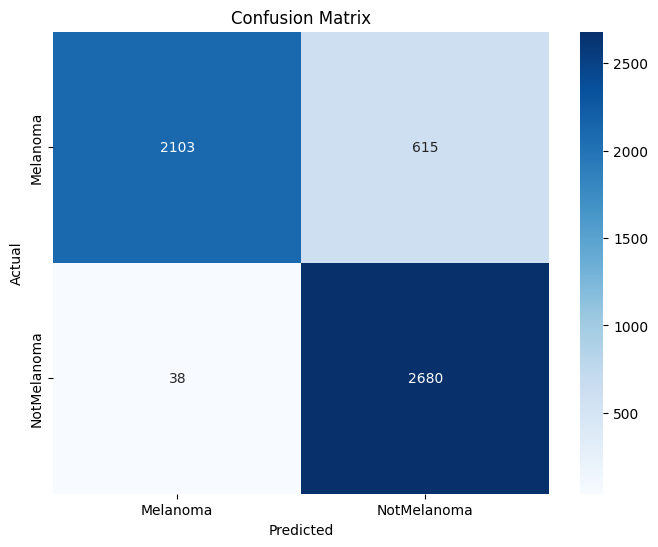

In [76]:
# Evaluar el modelo en el conjunto de pruebas
test_loss, test_accuracy, test_auc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')

# Ajustar el umbral
threshold = 0.3  # He bajado este umbral de 0.5 a 0.3 para minimizar los falsos negativos

# Calcular el número de steps exactos para cubrir todas las muestras
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Obtener predicciones de probabilidades (en lugar de clases)
predictions = model.predict(test_generator, steps=steps, verbose=1)

# Ajustar el umbral de clasificación: Si la probabilidad de Melanoma (columna 1) >= umbral, predice Melanoma (1), si no, NotMelanoma (0)
predicted_classes = (predictions[:, 1] >= threshold).astype(int)

# Asegúrate de que no falten imágenes al final del proceso
true_classes = test_generator.classes
assert len(true_classes) == len(predicted_classes), "Mismatch in number of predictions and true labels"

# Calcular AUC-ROC
auc = roc_auc_score(true_classes, predictions[:, 1])  # Usamos las probabilidades para calcular AUC-ROC
print(f'AUC-ROC: {auc:.2f}')

# Generar el reporte de clasificación
class_labels = list(test_generator.class_indices.keys())
if len(true_classes) == len(predicted_classes):
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)
else:
    print("Las longitudes de true_classes y predicted_classes no coinciden. No se puede generar el reporte.")

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### AJUSTE DEL UMBRAL DE CLASIFICACION

In [ ]:
threshold = 0.3  # Ajustar el umbral

# Obtener predicciones de probabilidades
predictions = model.predict(test_generator)

# Ajustar el umbral de clasificación
predicted_classes = (predictions[:, 1] >= threshold).astype(int)

In [71]:
# Guardar el modelo actualizado
model.save('models/melanoma_3-diagnosis2.keras')

# Revisar los datos mal clasificados

### Paso 1: Generar predicciones

In [72]:
# Calcular el número de steps exactos para cubrir todas las muestras
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Obtener las predicciones del modelo
predictions = model.predict(test_generator, steps=steps, verbose=1)

# Convertir las predicciones a etiquetas (0 o 1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas del generador de test
true_classes = test_generator.classes

# Nombres de las clases
class_labels = list(test_generator.class_indices.keys())

170/170 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step


### Paso 2: Identificar los falsos positivos y falsos negativos

In [73]:
# Falsos negativos: verdadero Melanoma (1), predicción incorrecta NotMelanoma (0)
false_negatives = np.where((true_classes == 1) & (predicted_classes == 0))[0]

# Falsos positivos: verdadero NotMelanoma (0), predicción incorrecta Melanoma (1)
false_positives = np.where((true_classes == 0) & (predicted_classes == 1))[0]

### Paso 3: Revisar las imágenes mal clasificadas

Falsos Negativos (Melanoma mal clasificado como NotMelanoma):


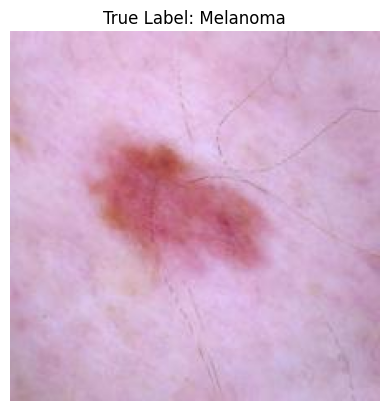

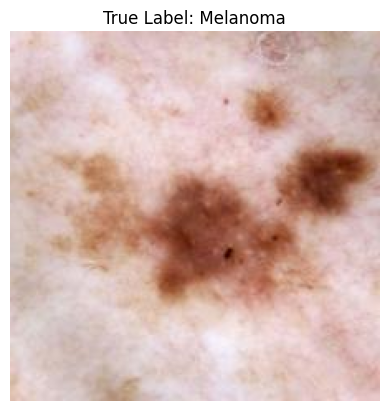

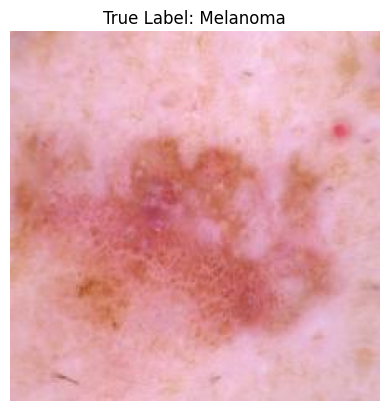

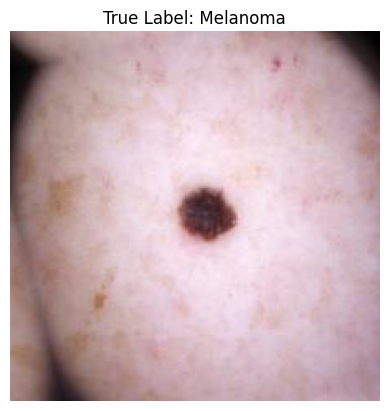

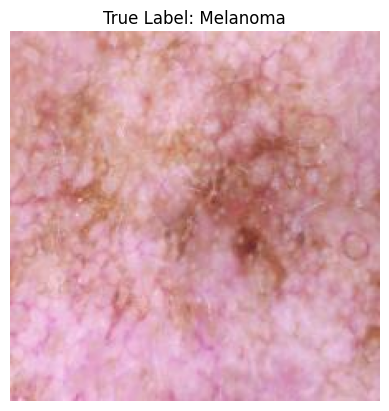

Falsos Positivos (NotMelanoma mal clasificado como Melanoma):


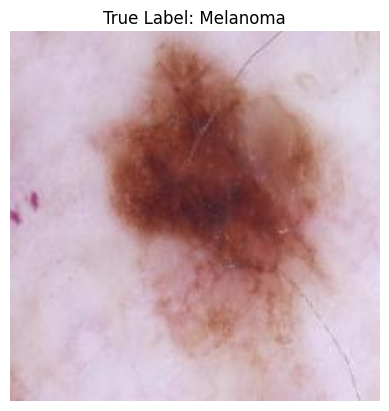

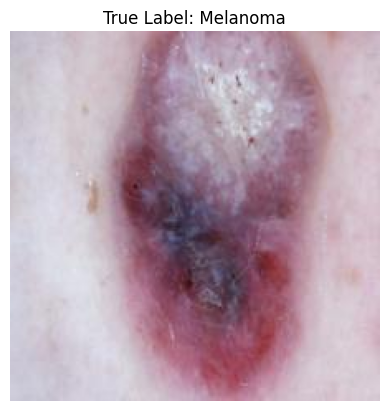

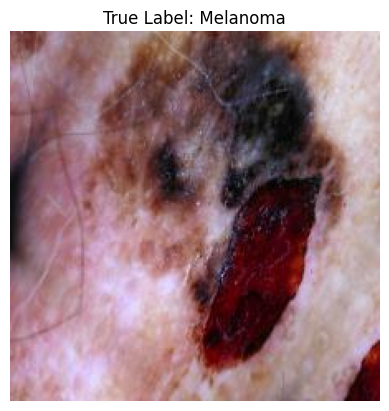

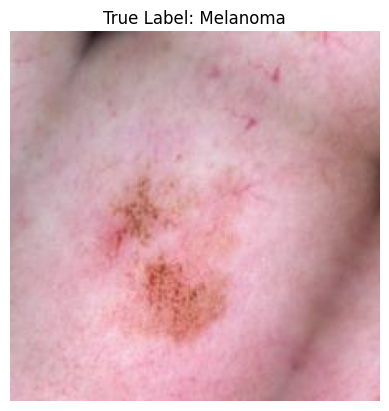

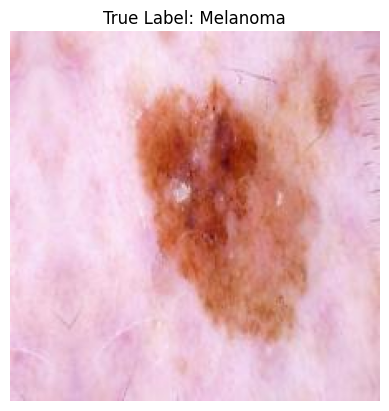

In [75]:
import matplotlib.pyplot as plt

# Función para mostrar una imagen de un generador de datos en un índice dado
def display_image_from_generator(generator, global_index):
    # Obtener el tamaño del batch (lote)
    batch_size = generator.batch_size
    
    # Encontrar el índice del batch y el índice dentro de ese batch
    batch_index = global_index // batch_size
    image_index_in_batch = global_index % batch_size

    # Obtener el batch correspondiente
    generator_batch = next(generator)
    images, labels = generator_batch
    
    # Mostrar la imagen y su etiqueta verdadera
    plt.imshow(np.squeeze(images[image_index_in_batch]))
    plt.title(f"True Label: {class_labels[np.argmax(labels[image_index_in_batch])]}")
    plt.axis('off')
    plt.show()

# Mostrar algunos falsos negativos
print("Falsos Negativos (Melanoma mal clasificado como NotMelanoma):")
for i in false_negatives[:5]:  # Mostramos los primeros 5
    display_image_from_generator(test_generator, i)

# Mostrar algunos falsos positivos
print("Falsos Positivos (NotMelanoma mal clasificado como Melanoma):")
for i in false_positives[:5]:  # Mostramos los primeros 5
    display_image_from_generator(test_generator, i)